In [38]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [7]:
# 1. Carregar os Dados
data_inmet = pd.read_csv('../../model/additional_data/datasets/inmet_2019_2024.csv')
data_modis = pd.read_csv('../../model/data/modisTodos.csv')

In [8]:
# Ajustar os tipos de dados para latitude e longitude
data_inmet['latitude'] = data_inmet['latitude'].str.replace(',', '.', regex=False).astype(float) if data_inmet['latitude'].dtype == 'object' else data_inmet['latitude']
data_inmet['longitude'] = data_inmet['longitude'].str.replace(',', '.', regex=False).astype(float) if data_inmet['longitude'].dtype == 'object' else data_inmet['longitude']
data_modis['latitude'] = data_modis['latitude'].str.replace(',', '.', regex=False).astype(float) if data_modis['latitude'].dtype == 'object' else data_modis['latitude']
data_modis['longitude'] = data_modis['longitude'].str.replace(',', '.', regex=False).astype(float) if data_modis['longitude'].dtype == 'object' else data_modis['longitude']

In [9]:
# 3. Verificar os Dados Originais
print("Dados do INMET:")
print(data_inmet.head())

Dados do INMET:
         Data   latitude  longitude  PRECIPITACAO TOTAL, HORARIO (mm)  \
0  2019-01-01 -15.789343 -47.925756                               1.4   
1  2019-01-02 -15.789343 -47.925756                               0.0   
2  2019-01-03 -15.789343 -47.925756                               0.0   
3  2019-01-04 -15.789343 -47.925756                               0.0   
4  2019-01-05 -15.789343 -47.925756                               1.0   

   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                             888.02       
1                                             888.80       
2                                             887.62       
3                                             887.54       
4                                             887.96       

   RADIACAO GLOBAL (KJ/m2)  TEMPERATURA DO AR - BULBO SECO, HORARIA (0C)  \
0                  1192.79                                         20.52   
1                  2300.98      

In [10]:
print("Dados do MODIS:")
print(data_modis.head())

Dados do MODIS:
   latitude  longitude  confidence
0  -33.7092   -53.3442         0.0
1  -33.6991   -53.3287         0.0
2  -33.3994   -52.9535         0.0
3  -33.3934   -52.9476         0.0
4  -33.3688   -52.9170         0.0


In [11]:
# Verificar tipos de dados
print(data_inmet[['latitude', 'longitude']].dtypes)
print(data_modis[['latitude', 'longitude']].dtypes)

latitude     float64
longitude    float64
dtype: object
latitude     float64
longitude    float64
dtype: object


In [12]:
# Verificar valores nulos
print("Valores nulos no INMET:")
print(data_inmet[['latitude', 'longitude']].isnull().sum())
print("Valores nulos no MODIS:")
print(data_modis[['latitude', 'longitude']].isnull().sum())

Valores nulos no INMET:
latitude     0
longitude    0
dtype: int64
Valores nulos no MODIS:
latitude     0
longitude    0
dtype: int64


In [13]:
print(data_inmet[['latitude', 'longitude']].head())
print(data_modis[['latitude', 'longitude']].head())

    latitude  longitude
0 -15.789343 -47.925756
1 -15.789343 -47.925756
2 -15.789343 -47.925756
3 -15.789343 -47.925756
4 -15.789343 -47.925756
   latitude  longitude
0  -33.7092   -53.3442
1  -33.6991   -53.3287
2  -33.3994   -52.9535
3  -33.3934   -52.9476
4  -33.3688   -52.9170


In [14]:
# Arredondar latitudes e longitudes do INMET para 4 casas decimais
data_inmet['latitude'] = data_inmet['latitude'].astype(float).round(4)
data_inmet['longitude'] = data_inmet['longitude'].astype(float).round(4)

# Verifique os resultados após a conversão
print("INMET Latitude e Longitude após conversão:")
print(data_inmet[['latitude', 'longitude']].head())

INMET Latitude e Longitude após conversão:
   latitude  longitude
0  -15.7893   -47.9258
1  -15.7893   -47.9258
2  -15.7893   -47.9258
3  -15.7893   -47.9258
4  -15.7893   -47.9258


In [15]:
# Função para combinar com tolerância
from sklearn.neighbors import NearestNeighbors

# Preparar os dados para Nearest Neighbors
inmet_coords = data_inmet[['latitude', 'longitude']].values
modis_coords = data_modis[['latitude', 'longitude']].values

In [16]:
# Ajustar o modelo Nearest Neighbors
nbrs = NearestNeighbors(n_neighbors=1, radius=0.01).fit(modis_coords)  # Ajuste o raio conforme necessário
distances, indices = nbrs.kneighbors(inmet_coords)

In [17]:
# Adicionar a coluna de índice mais próximo ao DataFrame do INMET
data_inmet['modis_index'] = indices.flatten()
data_inmet['distance'] = distances.flatten()

In [18]:
# Filtrar para manter apenas correspondências dentro de uma certa tolerância
tolerance = 0.1  # Ajuste conforme necessário
filtered_inmet = data_inmet[data_inmet['distance'] < tolerance]

In [19]:
# Fazer o merge
combined_data_tolerance = pd.merge(filtered_inmet, data_modis, left_on='modis_index', right_index=True, how='inner')

# Verifique o DataFrame combinado com tolerância
print("DataFrame Combinado com Tolerância:")
print(combined_data_tolerance.head())

DataFrame Combinado com Tolerância:
         Data  latitude_x  longitude_x  PRECIPITACAO TOTAL, HORARIO (mm)  \
0  2019-01-01    -15.7893     -47.9258                               1.4   
1  2019-01-02    -15.7893     -47.9258                               0.0   
2  2019-01-03    -15.7893     -47.9258                               0.0   
3  2019-01-04    -15.7893     -47.9258                               0.0   
4  2019-01-05    -15.7893     -47.9258                               1.0   

   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                             888.02       
1                                             888.80       
2                                             887.62       
3                                             887.54       
4                                             887.96       

   RADIACAO GLOBAL (KJ/m2)  TEMPERATURA DO AR - BULBO SECO, HORARIA (0C)  \
0                  1192.79                                         20.

In [20]:
print(combined_data_tolerance.isna().sum())  # Para verificar quantos NaNs existem em cada coluna

Data                                                     0
latitude_x                                               0
longitude_x                                              0
PRECIPITACAO TOTAL, HORARIO (mm)                         0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0
RADIACAO GLOBAL (KJ/m2)                                  0
TEMPERATURA DO AR - BULBO SECO, HORARIA (0C)             0
UMIDADE RELATIVA DO AR, HORARIA (%)                      0
VENTO, RAJADA MAXIMA (m/s)                               0
modis_index                                              0
distance                                                 0
latitude_y                                               0
longitude_y                                              0
confidence                                               0
dtype: int64


In [21]:
# Se o DataFrame combinado estiver vazio
if combined_data_tolerance.empty:
    print("O DataFrame combinado está vazio. Tentando um merge 'outer' para verificar divergências...")
    combined_data_tolerance = pd.merge(data_inmet, data_modis, on=['latitude', 'longitude'], how='outer')
    print(combined_data_tolerance.head())  # Exibir as primeiras linhas para verificar divergências
# 5. Modelagem (continua a partir daqui, se o DataFrame não estiver vazio)
if not combined_data_tolerance.empty:
    features = combined_data_tolerance[['PRECIPITACAO TOTAL, HORARIO (mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
                              'RADIACAO GLOBAL (KJ/m2)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (0C)',
                              'UMIDADE RELATIVA DO AR, HORARIA (%)', 'VENTO, RAJADA MAXIMA (m/s)']]
    target = combined_data_tolerance['confidence']  # Certifique-se de que 'confidence' existe

In [22]:
print(combined_data_tolerance.head()) 

         Data  latitude_x  longitude_x  PRECIPITACAO TOTAL, HORARIO (mm)  \
0  2019-01-01    -15.7893     -47.9258                               1.4   
1  2019-01-02    -15.7893     -47.9258                               0.0   
2  2019-01-03    -15.7893     -47.9258                               0.0   
3  2019-01-04    -15.7893     -47.9258                               0.0   
4  2019-01-05    -15.7893     -47.9258                               1.0   

   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                             888.02       
1                                             888.80       
2                                             887.62       
3                                             887.54       
4                                             887.96       

   RADIACAO GLOBAL (KJ/m2)  TEMPERATURA DO AR - BULBO SECO, HORARIA (0C)  \
0                  1192.79                                         20.52   
1                  2300.98    

In [23]:
# 6. Dividir os dados em treinamento e teste
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [24]:
# 7. Criar e treinar o modelo
model = GradientBoostingRegressor()
model.fit(x_train, y_train)

GradientBoostingRegressor()

In [25]:
# 8. Fazer previsões
predictions = model.predict(x_test)

In [39]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# Calcular acurácia baseada em margem de erro
margem_erro = 0.1  # 10%
acuracia = np.mean(np.abs(predictions - y_test) <= margem_erro * y_test) * 100

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Acurácia (margem de erro de {margem_erro*100}%): {acuracia:.2f}%")

MSE: 439.09
R²: 0.46
Acurácia (margem de erro de 10.0%): 31.65%


In [26]:
# 9. Gerar datas futuras
hoje = pd.to_datetime("2024-11-01")
datas_futuras = [hoje + timedelta(days=i) for i in range(8)]  # Gera hoje e os próximos 7 dias

In [27]:
# Número de previsões que você deseja para cada dia (ajuste conforme necessário)
previsoes_por_dia = 500  # Exemplo: 500 previsões diárias

In [28]:
# Repetir previsões para cada data e latitude/longitude
resultados = []

In [29]:
for data in datas_futuras:
    for i in range(previsoes_por_dia):
        # Amostra aleatória das características (ajuste para sua necessidade)
        sample_features = x_test.sample(1).values.reshape(1, -1)
        
        # Prever usando o modelo
        pred = model.predict(sample_features)[0]
        
        # Extrair latitude e longitude correspondentes da amostra
        latitude = combined_data_tolerance.loc[x_test.index, 'latitude_x'].sample(1).values[0]
        longitude = combined_data_tolerance.loc[x_test.index, 'longitude_x'].sample(1).values[0]
        
        # Adicionar aos resultados
        resultados.append({
            'Data': data,
            'latitude': latitude,
            'longitude': longitude,
            'probabilidade': pred
        })

c:\Users\Usuario\Documents\GitHub\fireforecast\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\fireforecast\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\fireforecast\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\fireforecast\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\fireforecast\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have val

In [30]:
# Criar DataFrame dos resultados
result_df = pd.DataFrame(resultados)

In [31]:
# Salvar os resultados em um arquivo CSV, se necessário
result_df.to_csv('resultados_previsao_boosting.csv', index=False)

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Carregar os dados
data_modis = pd.read_csv('../../model/data/modisTodos.csv')
data_inmet = pd.read_csv('../../model/additional_data/datasets/inmet_2019_2024.csv')
resultados_novos = pd.read_csv('resultados_previsao_boosting.csv')

In [35]:
# Configuração de estilo
sns.set(style="whitegrid")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3300\2356535753.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=resultados_novos, x='Data', y='probabilidade', color='red', ci=None)  # ci=None remove as margens


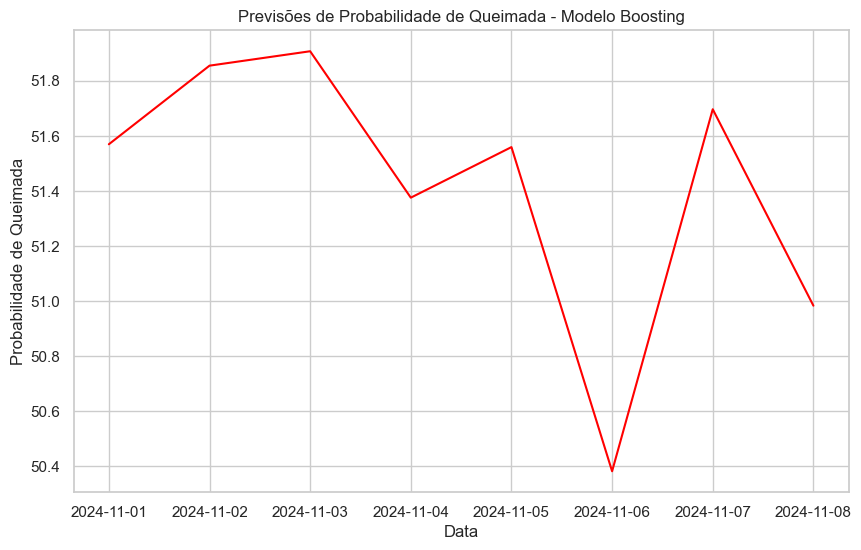

In [36]:
# Garantindo que as datas estão no formato correto e ordenando os dados
resultados_novos['Data'] = pd.to_datetime(resultados_novos['Data'])
resultados_novos = resultados_novos.sort_values(by='Data')

# Configuração do gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=resultados_novos, x='Data', y='probabilidade', color='red', ci=None)  # ci=None remove as margens

# Ajuste dos títulos e eixos
plt.title('Previsões de Probabilidade de Queimada - Modelo Boosting')
plt.xlabel('Data')
plt.ylabel('Probabilidade de Queimada')

# Exibir o gráfico
plt.show()